In [1]:
import pandas as pd
import numpy as np
import time, random
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import make_scorer

In [2]:
df = pd.read_csv('dataset/feature_set_all/train_set_2.csv')
df[df.select_dtypes(np.float64).columns] = df.select_dtypes(np.float64).astype(np.float32)
df.head(2)

,num,name,BBclass,Check,smiles,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,...,MFP_2039,MFP_2040,MFP_2041,MFP_2042,MFP_2043,MFP_2044,MFP_2045,MFP_2046,MFP_2047,MFP_2048
0,1,Propanolol,1,2,CC(C)NCC(O)COc1cccc2ccccc12,9.843954,-0.498733,9.843954,0.299333,0.837506,...,1,0,0,0,0,0,0,0,0,0
1,2,Terbutylchlorambucil,1,2,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,11.682268,-0.409691,11.682268,0.134704,0.474821,...,0,0,0,0,0,0,0,0,0,0


In [3]:
columns = df.columns.to_numpy()
check_features = columns[df.isin([np.inf, -np.inf, np.NaN]).any(axis=0).to_numpy()].tolist()
check_features, len(check_features)

(['Ipc'], 1)

In [4]:
lowVar_features = df.std()[df.std() < 0.14].index.tolist()
len(lowVar_features)

1351

In [5]:
#features = [x[0] for x in Descriptors._descList]
Fingerprints = ['MFP_%d'%(i+1) for i in range(2048)]
descriptors = ['HeavyAtomMolWt','NHOHCount','NOCount','RingCount']
features = Fingerprints + descriptors
features = [x for x in features if x not in check_features+lowVar_features]
len(features)

743

In [6]:
df.BBclass.value_counts()

1    1492
0     462
Name: BBclass, dtype: int64

In [7]:
X = np.c_[df[features]]
y = np.c_[df['BBclass']]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=0, 
                                                    shuffle=True, 
                                                    stratify=y)

In [8]:
random_state = 0
classifiers = {
    "DummyClassifier_most_frequent": DummyClassifier(strategy='most_frequent', random_state=random_state),
    "LogisticRegression": LogisticRegression(solver = 'lbfgs', max_iter=5000,random_state=random_state),
    "LGBMClassifier": LGBMClassifier(random_state=random_state),
    "XGBClassifier": XGBClassifier(eval_metric='mlogloss',use_label_encoder=False,random_state=random_state),
    "KNeighborsClassifier": KNeighborsClassifier(3),    
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=random_state),
    "RandomForestClassifier": RandomForestClassifier(random_state=random_state),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=random_state),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=random_state),
    "GaussianNB": GaussianNB(),
}

In [9]:
df_models = pd.DataFrame(columns=['model', 'run_time', 'avg_pre', 'avg_pre_std'])

for key in classifiers:

    print('*',key)

    start_time = time.time()

    classifier = classifiers[key]
    model = classifier.fit(X_train, y_train.ravel())
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=10)
    scorer = make_scorer(average_precision_score)
    cv_scores = cross_val_score(model, X_test, y_test.ravel(), cv=5, scoring=scorer)
    y_pred = model.predict(X_test)

    row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'avg_pre': cv_scores.mean(),
           'avg_pre_std': cv_scores.std(),
    }

    df_models = df_models.append(row, ignore_index=True)

* DummyClassifier_most_frequent
* LogisticRegression
* LGBMClassifier
* XGBClassifier
* KNeighborsClassifier
* DecisionTreeClassifier
* RandomForestClassifier
* AdaBoostClassifier
* GradientBoostingClassifier
* GaussianNB


In [10]:
df_models.sort_values(by='avg_pre', ascending=False)

,model,run_time,avg_pre,avg_pre_std
3,XGBClassifier,0.08,0.893089,0.015010
1,LogisticRegression,0.08,0.885455,0.014878
2,LGBMClassifier,0.01,0.884734,0.018125
8,GradientBoostingClassifier,0.08,0.877663,0.013571
6,RandomForestClassifier,0.03,0.873748,0.015181
5,DecisionTreeClassifier,0.01,0.871660,0.017780
7,AdaBoostClassifier,0.03,0.856581,0.012444
4,KNeighborsClassifier,0.0,0.838484,0.019713
9,GaussianNB,0.0,0.806414,0.015148
0,DummyClassifier_most_frequent,0.0,0.763204,0.003147


As XGB Classifier is the best one, let's take a look at other metrics of XGB Classifier

In [11]:
df_result = pd.DataFrame(columns=['model', 'tp', 'tn', 'fp', 'fn', 'correct', 'incorrect',
                                  'accuracy', 'precision', 'recall', 'f1', 'roc_auc','avg_pre'])

classifier = XGBClassifier(eval_metric='mlogloss',use_label_encoder=False,random_state=random_state)
model = classifier.fit(X_train, y_train)
y_pred = model.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
avg_precision = average_precision_score(y_test, y_pred)

row = {'model': 'XGBClassifier without SMOTE',
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'correct': tp+tn,
        'incorrect': fp+fn,
        'accuracy': round(accuracy,3),
        'precision': round(precision,3),
        'recall': round(recall,3),
        'f1': round(f1,3),
        'roc_auc': round(roc_auc,3),
        'avg_pre': round(avg_precision,3),
    }

df_result = df_result.append(row, ignore_index=True)
df_result.head()

,model,tp,tn,fp,fn,correct,incorrect,accuracy,precision,recall,f1,roc_auc,avg_pre
0,XGBClassifier without SMOTE,434,85,54,14,519,68,0.884,0.889,0.969,0.927,0.79,0.885


Text(0.5, 1.0, 'Precision-Recall curve: ~0.8854')

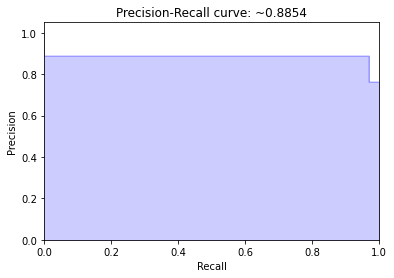

In [12]:
avg_precision = average_precision_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.00])
plt.title('Precision-Recall curve: ~{0:0.4f}'.format(avg_precision))

### Fit a model using SMOTE

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=0, 
                                                    shuffle=True, 
                                                    stratify=y)

In [14]:
oversampled = SMOTE(random_state=random_state)
X_train_smote, y_train_smote = oversampled.fit_resample(X_train, y_train)

In [15]:
y_train_smote.mean()

0.5

In [16]:
classifier = XGBClassifier(eval_metric='mlogloss',use_label_encoder=False,random_state=random_state)
model = classifier.fit(X_train_smote, y_train_smote)
y_pred_smote = model.predict(X_test)

In [17]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_smote).ravel()
accuracy = accuracy_score(y_test, y_pred_smote)
precision = precision_score(y_test, y_pred_smote)
recall = recall_score(y_test, y_pred_smote)
f1 = f1_score(y_test, y_pred_smote)
roc_auc = roc_auc_score(y_test, y_pred_smote)
avg_precision = average_precision_score(y_test, y_pred_smote)

row = {'model': 'XGBClassifier with SMOTE',
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'correct': tp+tn,
        'incorrect': fp+fn,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_pre': round(avg_precision,3),       
    }

In [18]:
df_result = df_result.append(row, ignore_index=True)
df_result.head()

,model,tp,tn,fp,fn,correct,incorrect,accuracy,precision,recall,f1,roc_auc,avg_pre
0,XGBClassifier without SMOTE,434,85,54,14,519,68,0.884000,0.889000,0.96900,0.927000,0.790000,0.885
1,XGBClassifier with SMOTE,434,90,49,14,524,63,0.892675,0.898551,0.96875,0.932331,0.808116,0.894


Text(0.5, 1.0, 'Precision-Recall curve: ~0.8943')

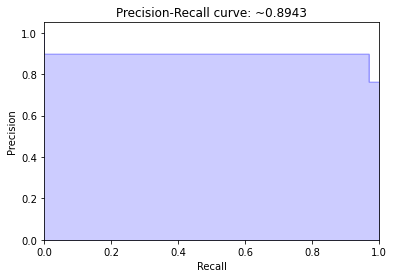

In [19]:
avg_precision = average_precision_score(y_test, y_pred_smote)
precision, recall, _ = precision_recall_curve(y_test, y_pred_smote)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: ~{0:0.4f}'.format(avg_precision))

### Using under-sampling and SMOTE over-sampling

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=0, 
                                                    shuffle=True, 
                                                    stratify=y)

In [21]:
oversampled = SMOTE(sampling_strategy=0.6, 
                    random_state=0,
                    k_neighbors=4)
X_train_smote, y_train_smote = oversampled.fit_resample(X_train, y_train)

In [22]:
y_train_smote.mean()

0.6251497005988024

In [23]:
undersampled = RandomUnderSampler(sampling_strategy=1.0, random_state=0)
X_train_final, y_train_final = undersampled.fit_resample(X_train_smote, y_train_smote)

In [24]:
y_train_final.mean()

0.5

In [25]:
classifier = XGBClassifier(eval_metric='mlogloss',use_label_encoder=False,random_state=random_state)
model = classifier.fit(X_train_final, y_train_final)

In [26]:
y_pred_smote = model.predict(X_test)

In [27]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_smote).ravel()
accuracy = accuracy_score(y_test, y_pred_smote)
precision = precision_score(y_test, y_pred_smote)
recall = recall_score(y_test, y_pred_smote)
f1 = f1_score(y_test, y_pred_smote)
roc_auc = roc_auc_score(y_test, y_pred_smote)
avg_precision = average_precision_score(y_test, y_pred_smote)

row = {'model': 'XGBClassifier with under/over',
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'correct': tp+tn,
        'incorrect': fp+fn,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_pre': round(avg_precision,3),       
    }

In [28]:
df_result = df_result.append(row, ignore_index=True)
df_result.tail(20)

,model,tp,tn,fp,fn,correct,incorrect,accuracy,precision,recall,f1,roc_auc,avg_pre
0,XGBClassifier without SMOTE,434,85,54,14,519,68,0.884000,0.889000,0.969000,0.927000,0.790000,0.885
1,XGBClassifier with SMOTE,434,90,49,14,524,63,0.892675,0.898551,0.968750,0.932331,0.808116,0.894
2,XGBClassifier with under/over,413,101,38,35,514,73,0.875639,0.915743,0.921875,0.918799,0.824247,0.904


Text(0.5, 1.0, 'Precision-Recall curve: ~0.9038')

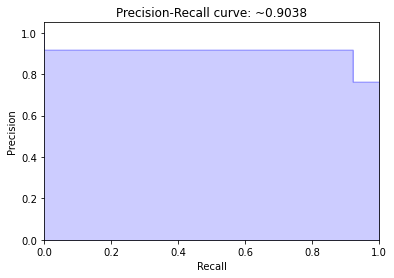

In [29]:
avg_precision = average_precision_score(y_test, y_pred_smote)
precision, recall, _ = precision_recall_curve(y_test, y_pred_smote)

plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: ~{0:0.4f}'.format(avg_precision))

### Borderline SMOTE

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=0, 
                                                    shuffle=True, 
                                                    stratify=y)

In [31]:
oversampled = BorderlineSMOTE(random_state=0)
X_train_smote, y_train_smote = oversampled.fit_resample(X_train, y_train)

In [32]:
y_train_smote.mean()

0.5

In [33]:
classifier = XGBClassifier(eval_metric='mlogloss',use_label_encoder=False,random_state=random_state)
model = classifier.fit(X_train_smote, y_train_smote)

In [34]:
y_pred_smote = model.predict(X_test)

In [35]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_smote).ravel()
accuracy = accuracy_score(y_test, y_pred_smote)
precision = precision_score(y_test, y_pred_smote)
recall = recall_score(y_test, y_pred_smote)
f1 = f1_score(y_test, y_pred_smote)
roc_auc = roc_auc_score(y_test, y_pred_smote)
avg_precision = average_precision_score(y_test, y_pred_smote)

row = {'model': 'XGBClassifier with Borderline SMOTE',
        'tp': tp,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'correct': tp+tn,
        'incorrect': fp+fn,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'avg_pre': round(avg_precision,3),       
    }

In [36]:
df_result = df_result.append(row, ignore_index=True)
df_result.head()

,model,tp,tn,fp,fn,correct,incorrect,accuracy,precision,recall,f1,roc_auc,avg_pre
0,XGBClassifier without SMOTE,434,85,54,14,519,68,0.884000,0.889000,0.969000,0.927000,0.790000,0.885
1,XGBClassifier with SMOTE,434,90,49,14,524,63,0.892675,0.898551,0.968750,0.932331,0.808116,0.894
2,XGBClassifier with under/over,413,101,38,35,514,73,0.875639,0.915743,0.921875,0.918799,0.824247,0.904
3,XGBClassifier with Borderline SMOTE,432,89,50,16,521,66,0.887564,0.896266,0.964286,0.929032,0.802287,0.892
